In [24]:
# imports
from dotenv import load_dotenv
import os

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

import openai

In [25]:
# set OpenAI API key
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [26]:
# load data
datafile_path = "../data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values) # convert list of arrays of embedding values to 2D numpy array
print(matrix)
print(matrix.shape)

[[ 0.00707925 -0.02723106  0.01061888 ... -0.00700708 -0.02184258
  -0.0375269 ]
 [-0.02364021 -0.01187362  0.00052846 ... -0.01462295  0.00727134
  -0.03325951]
 [ 0.00024283  0.00527809  0.00260073 ...  0.01035625 -0.0060678
  -0.01219559]
 ...
 [-0.01685294 -0.00515346  0.00619384 ... -0.01831336 -0.00988042
  -0.02229396]
 [-0.01073169 -0.01646377  0.02217569 ... -0.01760616 -0.03120725
  -0.00421002]
 [-0.00610347 -0.01505502 -0.00202363 ... -0.02909333 -0.0141817
  -0.02290188]]
(1000, 1536)


In [27]:
# 1.Find the clusters using K-means
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels # add cluster labels generated from kmeans to dataframe
df.groupby("Cluster").Score.mean().sort_values() # show average score for each cluster

/Users/godpeny/Code/venv/openai-research/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
2    4.081560
1    4.191176
0    4.221805
3    4.344937
Name: Score, dtype: float64

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997     True
998    False
999     True
Name: Cluster, Length: 1000, dtype: bool
0
0      False
1      False
2      False
3      False
4       True
       ...  
995    False
996     True
997    False
998    False
999    False
Name: Cluster, Length: 1000, dtype: bool
1
0       True
1       True
2      False
3      False
4      False
       ...  
995     True
996    False
997    False
998     True
999    False
Name: Cluster, Length: 1000, dtype: bool
2
0      False
1      False
2       True
3       True
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Cluster, Length: 1000, dtype: bool
3


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

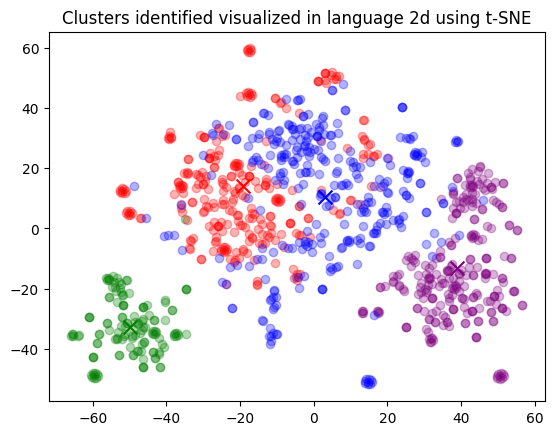

In [28]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category] # where cluster == category
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [33]:
# 2.Text samples in the clusters & naming the clusters
# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42) # pick sample of reviews
        .values
    )

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme: 5, breakfast tea:   We switch to this decaf tea at night for a great cup of tea and no sle
5, It is awesome.:   My partner is very happy with the tea, and is feeling much better sinc
4, Chike!:   Just tried the orange and iced coffee this morning and really liked th
5, FAVORITE tea...:   Lipton makes the BEST French Vanilla tea...I have tried others and thi
5, Twinings---a good cup of tea:   I have been drinking Twining's tea for years.  It used to be made in E
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: 

RateLimitError: The server had an error while processing your request. Sorry about that!